## Imports

In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2018-02-27 11:19:46


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [83]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pkf
import invisible_cities.reco.calib_sensors_functions as csf

from   invisible_cities.evm.ic_containers  import S12Params 
from   invisible_cities.evm.ic_containers  import CalibVectors
from   invisible_cities.evm.ic_containers  import DeconvParams
from   invisible_cities.evm.ic_containers  import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.icaro.signal_functions_mpl as sf
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.sierpe                 import blr

In [11]:
from invisible_cities.reco.dst_functions  import load_dst

In [109]:
from invisible_cities.evm .pmaps             import S1
from invisible_cities.evm .pmaps             import S2

## NB functions

In [72]:
def plot_csum_csum_mau(csum, csum_mau,
                            t_min      =    0,
                            t_max      = 1200,
                            signal_min =    0,
                            signal_max =  200,
                            figsize=(6,6)):
    """Plot signal versus time in mus (tmin, tmax in mus). """
    plt.figure(figsize=figsize)
    tstep = 25 # in ns
    PMTWL = csum.shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    ax1 = plt.subplot(1, 1, 1)
    ax1.set_xlim([t_min, t_max])
    ax1.set_ylim([signal_min, signal_max])
    mpl.set_plot_labels(xlabel = "t (mus)",
                    ylabel = "signal (pes/adc)")
    plt.plot(signal_t, csum, 'b')
    plt.plot(signal_t, csum_mau, 'r')

In [140]:
def plot_S12(s12s):
    plt.grid(True)
    plt.xlabel(r't (ns)')
    plt.ylabel(r'q (pes)')
    for s12 in s12s:
        plt.plot(s12.times, s12.pmts.waveform(-1))

In [155]:
def plot_pmt_signals_vs_time_mus(pmt_signals,
                                 pmt_active,
                                 t_min      =    0,
                                 t_max      = 1200,
                                 signal_min =    0,
                                 signal_max =  200,
                                 figsize=(12,12)):
    """Plot PMT signals versus time in mus  and return figure."""

    tstep = 25
    PMTWL = pmt_signals[0].shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    plt.figure(figsize=figsize)
   
   
    plt.ylabel(r'q (pes/adc)')
    for j, i in enumerate(pmt_active):
        plt.grid(True)
        ax1 = plt.subplot(3, 4, j+1)
        ax1.set_xlim([t_min, t_max])
        ax1.set_ylim([signal_min, signal_max])
        plt.plot(signal_t, pmt_signals[i])
        plt.xlabel(r't (mus)')


## Data base

In [13]:
run_number = 5054
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [14]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [15]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,0,PMT1,1,-23.9414,65.7785,0.000530,4.250400e-07,27.346,0.77,11.551
1,1,12,PMT3,1,-44.9951,-53.6231,0.000533,3.599900e-07,28.257,0.00,12.848
2,2,1,PMT2,1,68.9365,-12.1554,0.000530,5.525500e-07,29.983,0.81,12.072
3,3,13,PMT4,1,0.0000,185.0000,0.000526,3.563900e-07,30.131,0.00,12.006
4,4,19,PMTC,1,-118.9160,141.7180,0.000520,3.804100e-07,36.064,0.75,13.448
5,5,18,PMTB,1,-182.1890,32.1249,0.000529,5.704900e-07,26.945,0.75,9.687
6,6,7,PMTA,1,-160.2150,-92.5000,0.000518,5.597400e-07,31.032,0.00,11.675
7,7,6,PMT9,1,-63.2737,-173.8430,0.000528,5.918400e-07,40.055,0.00,15.462
8,8,17,PMT8,1,63.2737,-173.8430,0.000528,5.030400e-07,28.566,0.00,11.466
9,9,16,PMT7,1,160.2150,-92.5000,0.000527,4.763500e-07,0.000,0.00,0.000


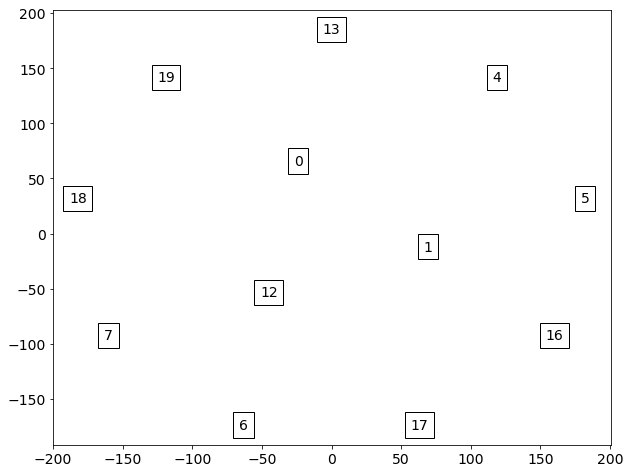

In [24]:
mpl.draw_pmt_map(run_number)

In [25]:
pmt_active

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [58]:
adc_to_pes

array([ 27.346,  28.257,  29.983,  30.131,  36.064,  26.945,  31.032,
        40.055,  28.566,   0.   ,  26.082,  27.499])

In [134]:
adc_to_pes[9] = 25

In [135]:
adc_to_pes

array([ 27.346,  28.257,  29.983,  30.131,  36.064,  26.945,  31.032,
        40.055,  28.566,  25.   ,  26.082,  27.499])

## Input file

In [136]:
filename = '/Users/jjgomezcadenas/Projects/ICDEV/data/run_5054_0090_waveforms.h5'
input_files = [filename]
h5rwf = tb.open_file(filename, "r") 

In [20]:
pmtrwf = h5rwf.root.RD.pmtrwf

In [21]:
NEVT, NPMT, PMTWL = pmtrwf.shape

In [22]:
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
      """.format(NEVT, NPMT, PMTWL))


        Number of events in file = 396
        Number of PMTs = 12
        PMTWL = 52000
      


## S1 and S2 parameters

In [111]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 640 * units.mus),
                           stride = 4,
                           length = minmax(min = 4, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)

In [167]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)

## Events

## Event 1

In [252]:
event=1

- Waveforms look similar to previous run, with grass being very visible after S2

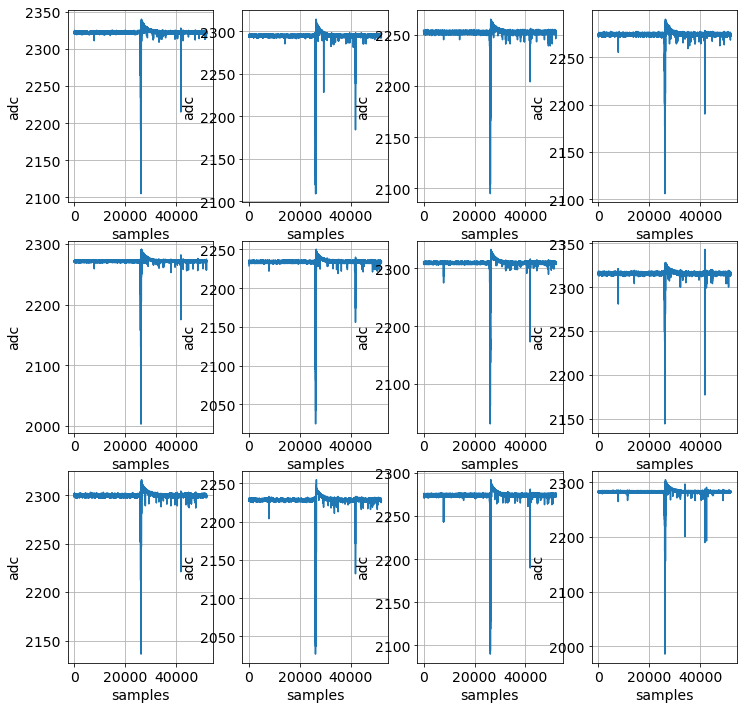

In [253]:
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

- Zoom to show the effect of the HPF in the RWF

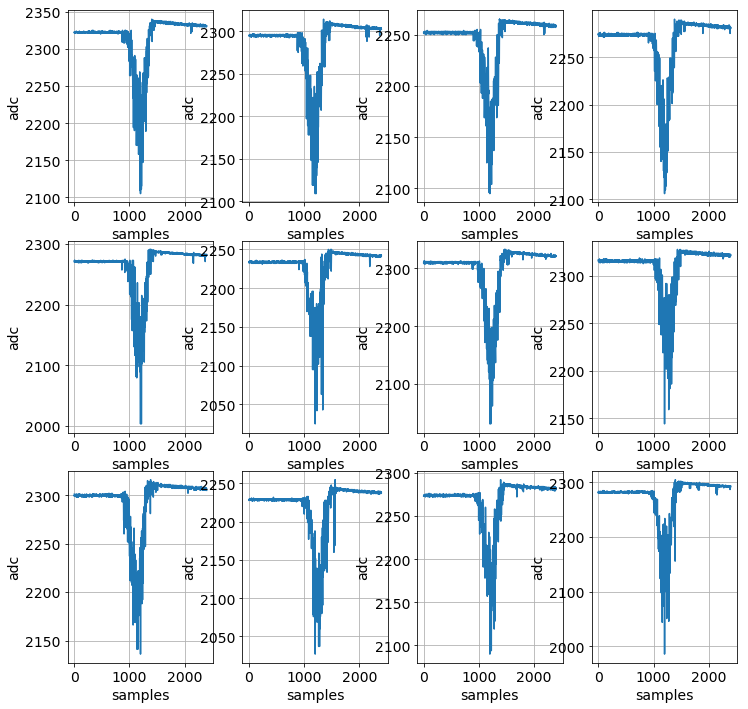

In [254]:
sf.plot_pmt_waveforms(pmtrwf[event], zoom=True, window_size=1200, figsize=(12,12))

- Deconvolution seems quite accurate

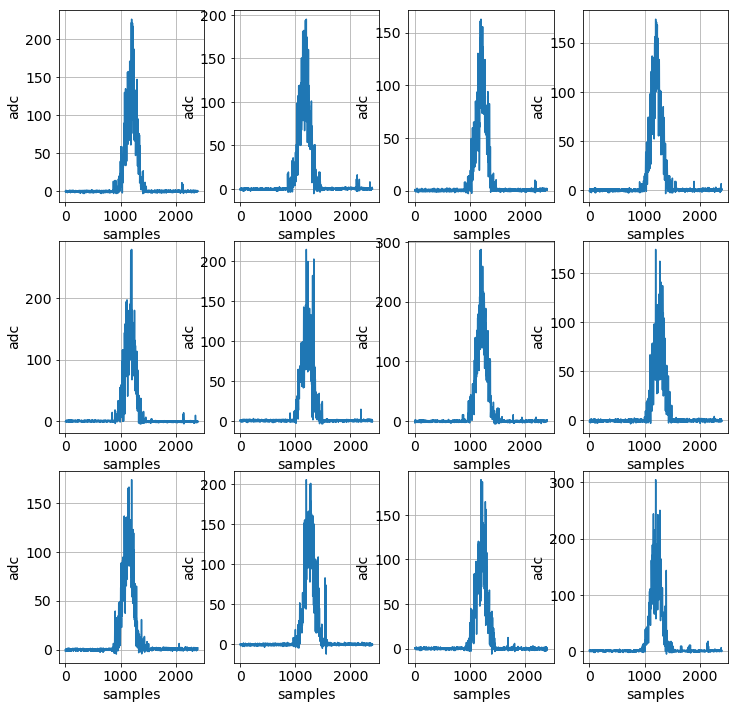

In [267]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

- Calibrated signal in all PMTs

In [259]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

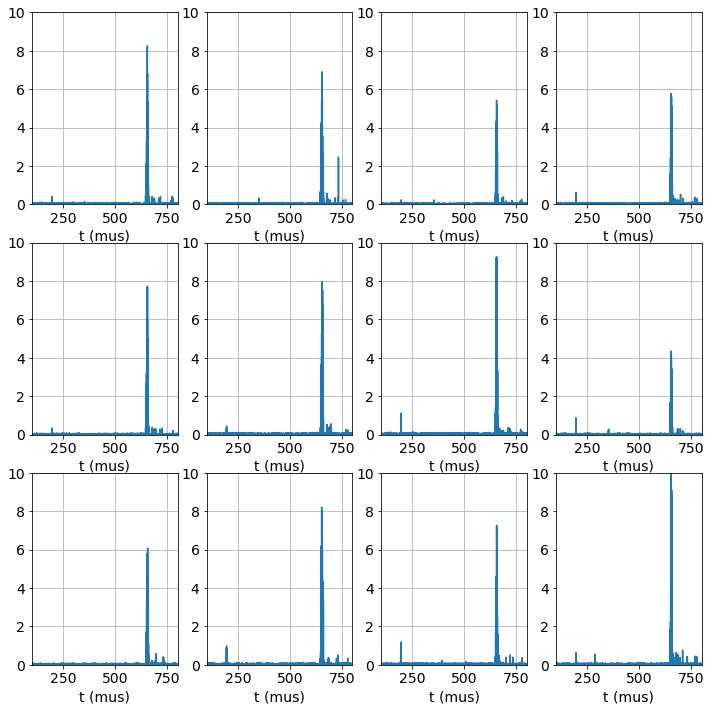

In [268]:
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    100,
                                t_max      = 800,
                                signal_min =    0,
                                signal_max =  10,
                                 figsize=(12,12))

- Calibrated sum

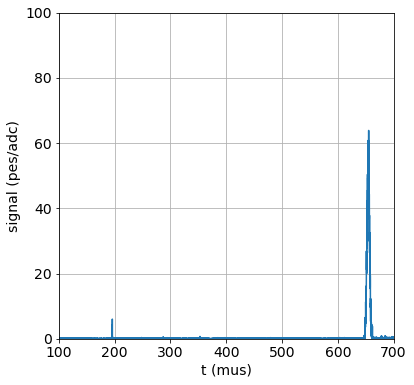

In [261]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =100,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

- Zoom to the S1 signal shows a problem. S1 has a "double peak structure"

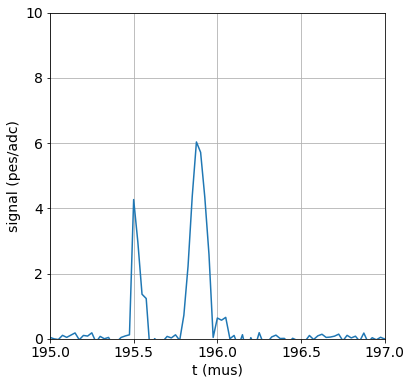

In [263]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =195,
                            t_max      = 197,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

- The structure appears also in individual PMTs. 

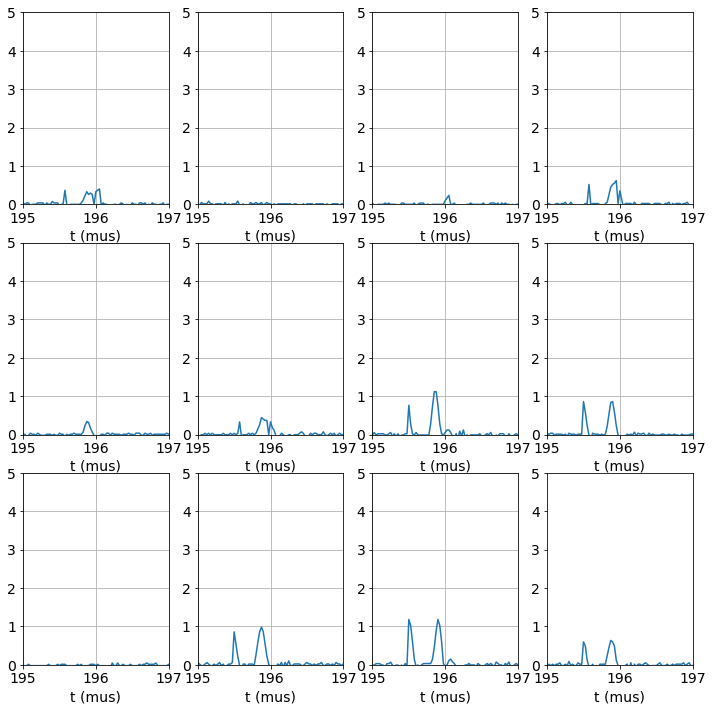

In [266]:
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    195,
                                t_max      = 197,
                                signal_min =    0,
                                signal_max =  5,
                                 figsize=(12,12))

#### Search for S1 and S2a

In [110]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)

In [269]:
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)

- Algorithm finds 2 S1s (as it should) due to double peak. 

In [113]:
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 195.5    195.525  195.55   195.575] µs
 Time @ max energy: 195.5
 Width: 0.075 µs
 Height: 3.410094321600236 pes
 Energy: 8.244316944621106 pes
 Charge: 0.0 pes
 RMS: 0.026940235548863097 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 10
       Times: [ 195.825  195.85   195.875  195.9    195.925  195.95   195.975  196.
 196.025  196.05 ] µs
       Time @ max energy: 195.875
       Width: 0.225 µs
       Height: 5.055282146450261 pes
       Energy: 23.42042558746048 pes
       Charge: 0.0 pes
       RMS: 0.05198950425197255 µs]

In [114]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)

In [116]:
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)

- The value of S2 is 11,000 pes (for a drift of 450 mm) which if it corresponds to Krypton appears to be good. 

In [117]:
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 16
       Times: [ 646.96303758  648.07245958  649.04891538  650.01271205  651.02016971
 651.98150004  652.96262283  653.95599135  654.93527157  655.92386962
 656.91145374  657.89781456  658.88463241  659.82947953  660.85646382
 661.756059  ] µs
       Time @ max energy: 654.9352715659664
       Width: 14.793021411467693 µs
       Height: 1994.550948354632 pes
       Energy: 11097.116191696594 pes
       Charge: 0.0 pes
       RMS: 2.268960951369623 µs]

In [119]:
s2s[0].times

array([ 646963.03758402,  648072.45958427,  649048.91537551,
        650012.71205124,  651020.16970633,  651981.50003824,
        652962.62282671,  653955.99135301,  654935.27156597,
        655923.86961781,  656911.45374311,  657897.81455688,
        658884.63241167,  659829.47953114,  660856.46382295,
        661756.05899548])

In [122]:
s2s[0].pmts.waveform(-1)

array([   10.04807453,    14.0620286 ,   104.48966312,   265.49243737,
         579.93767396,  1041.45096995,  1432.66551614,  1718.68497246,
        1994.55094835,  1652.77436629,  1101.31245814,   710.86571138,
         287.65744681,   121.00217266,    40.77062371,    21.35112822])

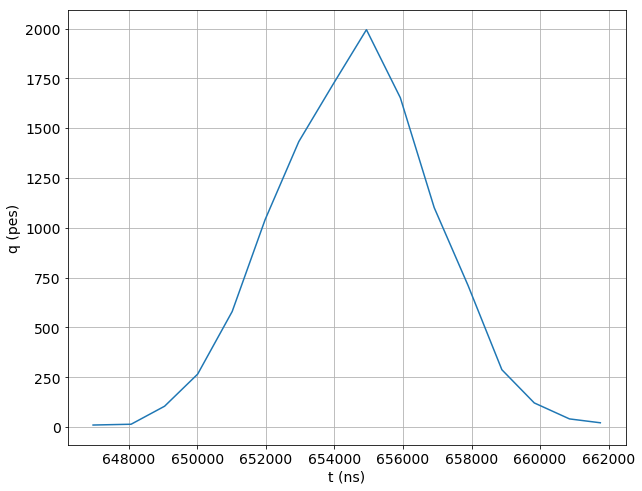

In [133]:
plot_S12(s2s)

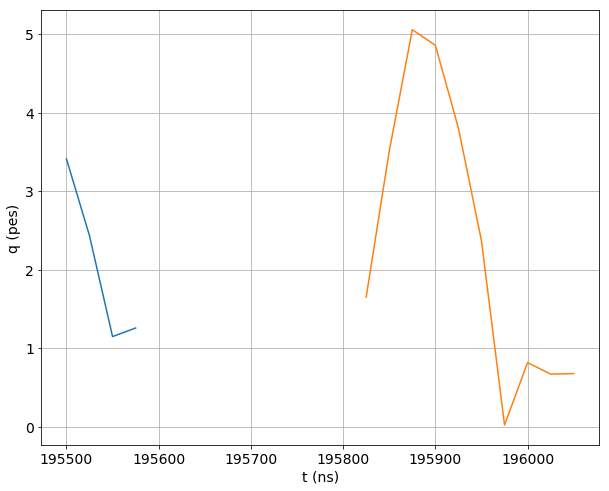

In [139]:
plot_S12(s1s)

## Event 2

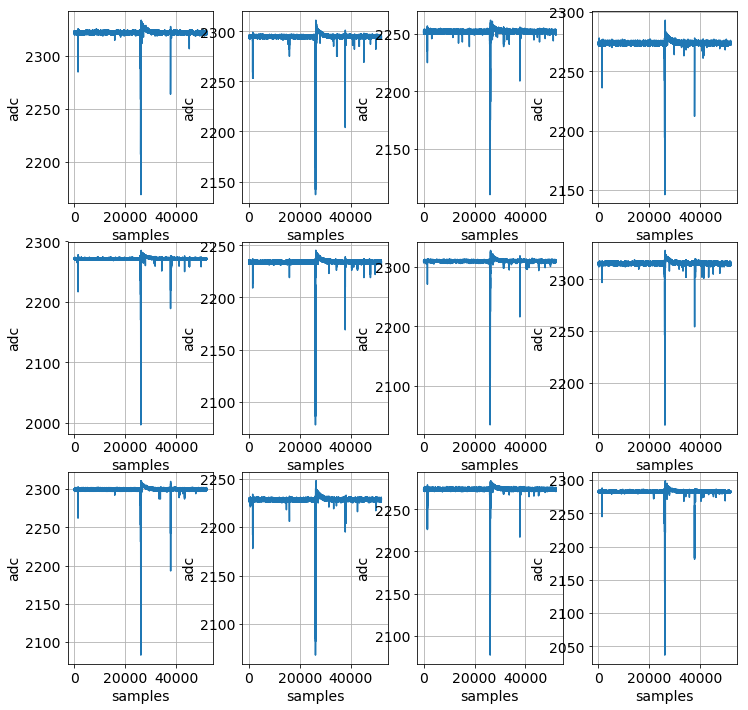

In [141]:
event=2
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

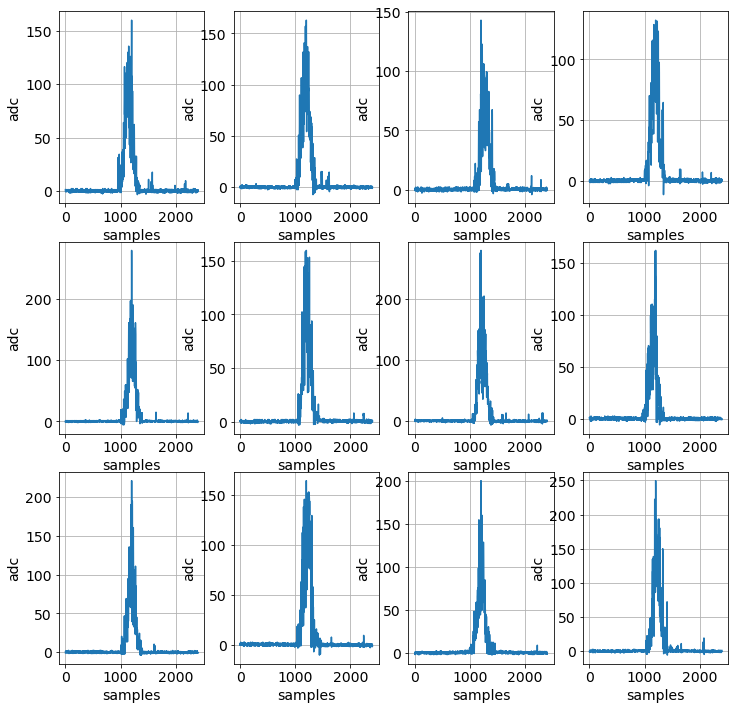

In [143]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

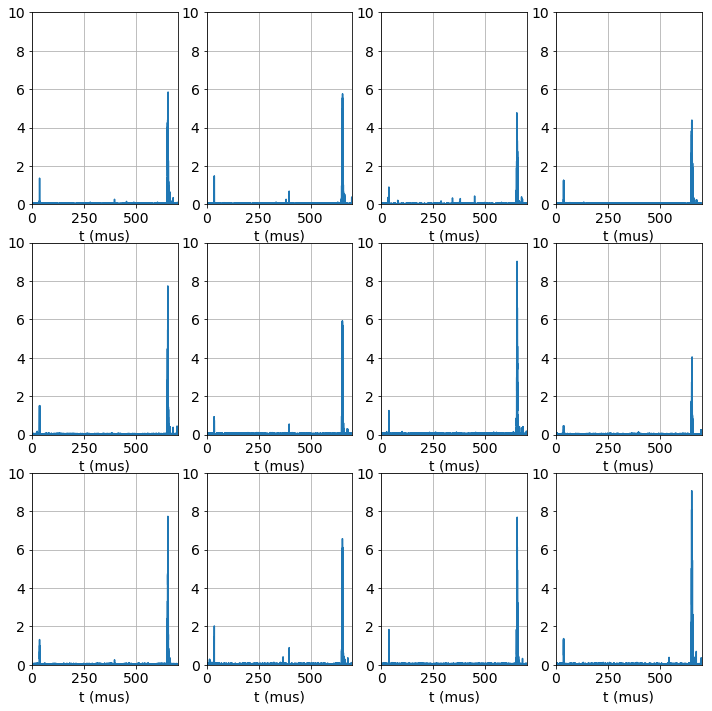

In [159]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    0,
                                t_max      = 700,
                                signal_min =    0,
                                signal_max =  10,
                                 figsize=(12,12))

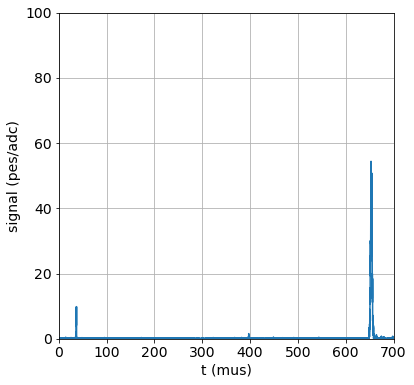

In [160]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

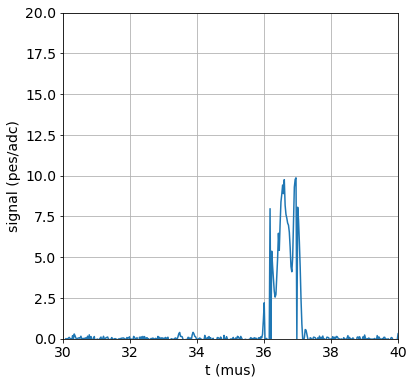

In [162]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =30,
                            t_max      = 40,
                            signal_min =    0,
                            signal_max =  20,
                            figsize=(6,6))

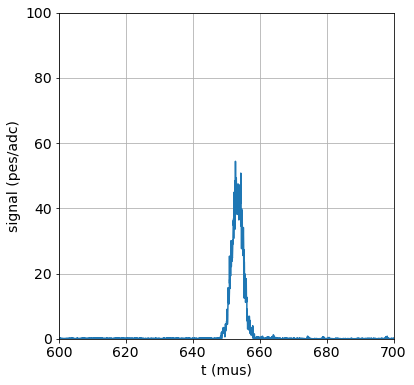

In [164]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

In [165]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 10
       Times: [ 397.     397.025  397.05   397.075  397.1    397.125  397.15   397.175
 397.2    397.225] µs
       Time @ max energy: 397.025
       Width: 0.225 µs
       Height: 1.5937113765277608 pes
       Energy: 10.175732859688784 pes
       Charge: 0.0 pes
       RMS: 0.0776879736441146 µs]

In [168]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 13
       Times: [ 648.95064014  649.91790608  650.87771348  651.82365465  652.79631976
 653.78991985  654.7375991   655.7230419   656.7381448   657.70275128
 658.6333491   659.70848405  660.61473292] µs
       Time @ max energy: 652.7963197631319
       Width: 11.66409278585529 µs
       Height: 1722.0724948269226 pes
       Energy: 7484.208779930386 pes
       Charge: 0.0 pes
       RMS: 1.613824200927815 µs, 
 ---------------------
 S2 instance
 ---------------------
 Number of samples: 3
 Times: [ 662.53486921  663.92629189  664.35861707] µs
 Time @ max energy: 663.9262918857829
 Width: 1.8237478622735943 µs
 Height: 12.38221085751701 pes
 Energy: 22.31054421150162 pes
 Charge: 0.0 pes
 RMS: 0.6843688089340965 µs]

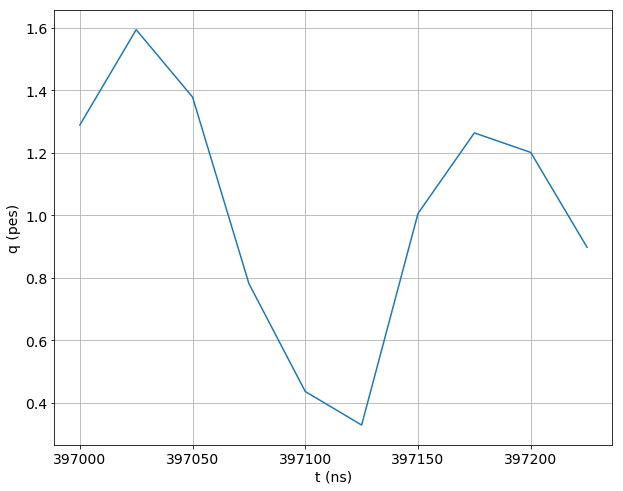

In [169]:
plot_S12(s1s)

- A second "fake" S2 appears as a consequence of the long tail. 

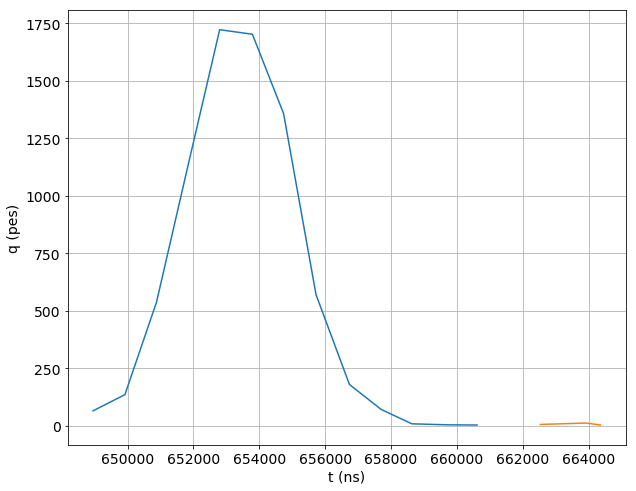

In [170]:
plot_S12(s2s)

- Repeat search rising threshold for S2.

In [270]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 648.70072653  649.66381752  650.678766    651.65606818  652.63988717
 653.61900037  654.61594392  655.58320442  656.56569644  657.56725464
 658.53077067  659.5430227   660.51445007  661.62537538] µs
       Time @ max energy: 654.6159439229183
       Width: 12.92464885085111 µs
       Height: 2203.562850790142 pes
       Energy: 12362.19259177607 pes
       Charge: 0.0 pes
       RMS: 2.2591161145243 µs]

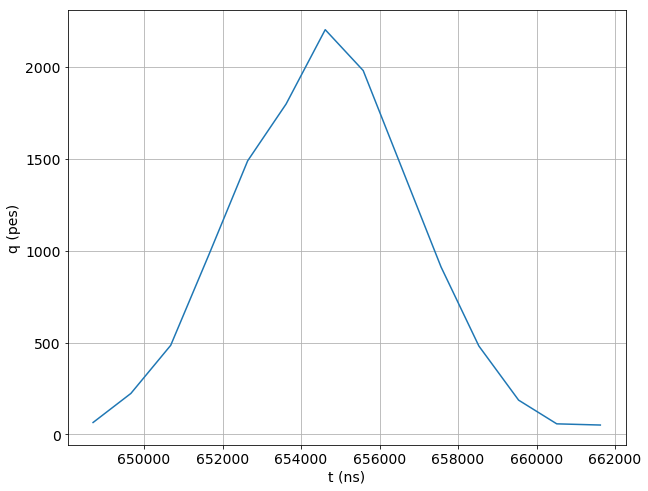

In [271]:
plot_S12(s2s)

#### Search for S2 can use a threshold a bit higher (1 pes) to avoid tails. 

- Notice that the event has drifter the full chamber and still has 12,362 pes. If this is a Krypton then lifetime must be very high. 

## Event 3

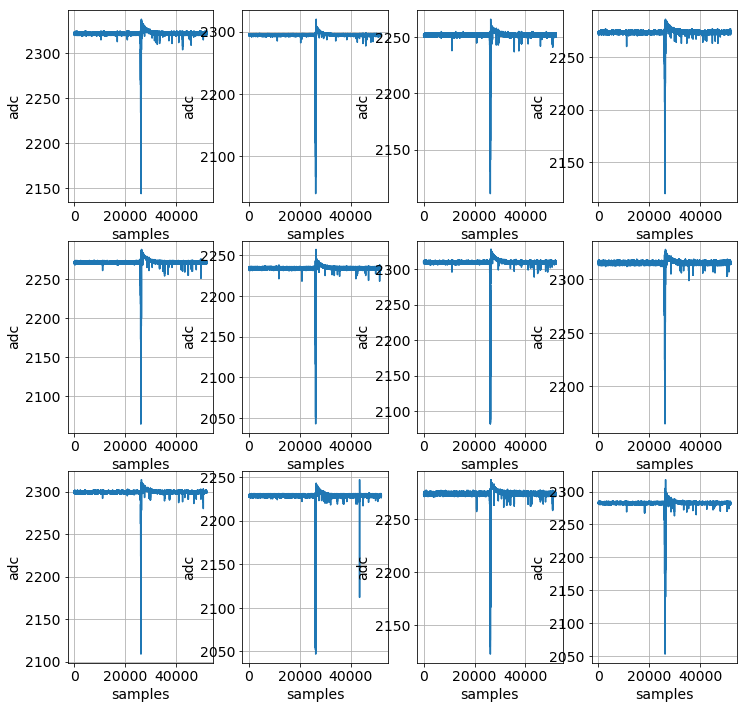

In [171]:
event=3
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

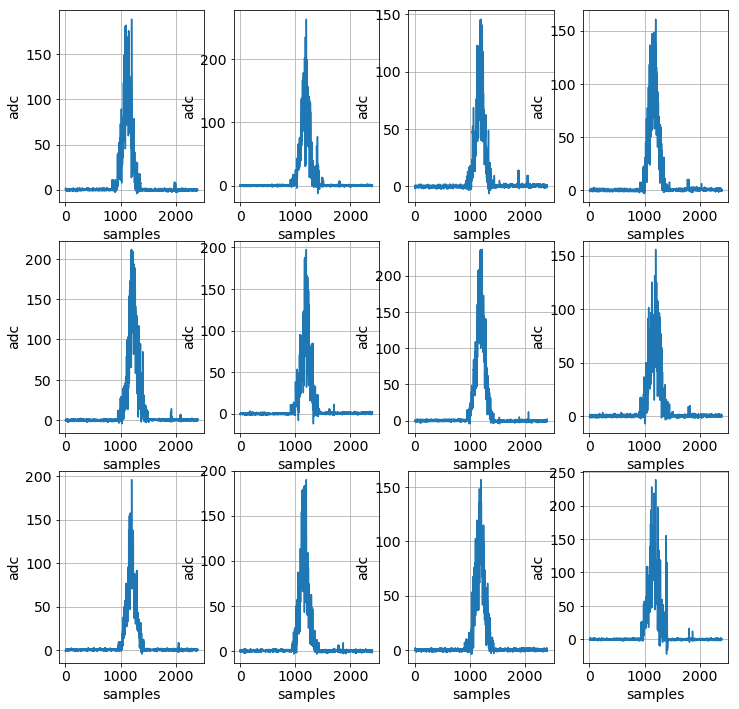

In [172]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

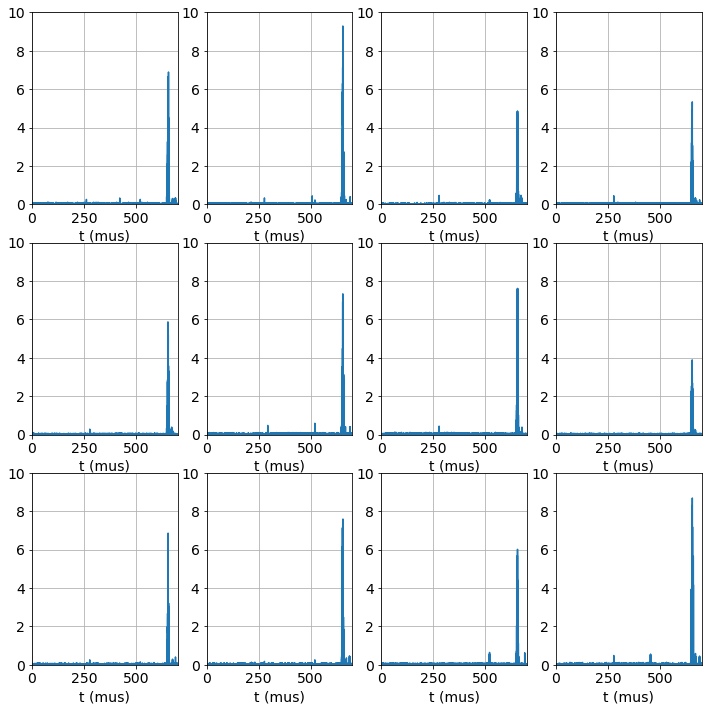

In [173]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    0,
                                t_max      = 700,
                                signal_min =    0,
                                signal_max =  10,
                                 figsize=(12,12))

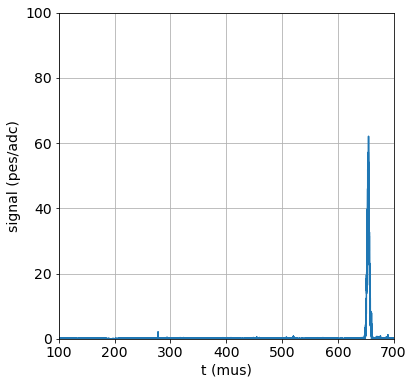

In [174]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =100,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

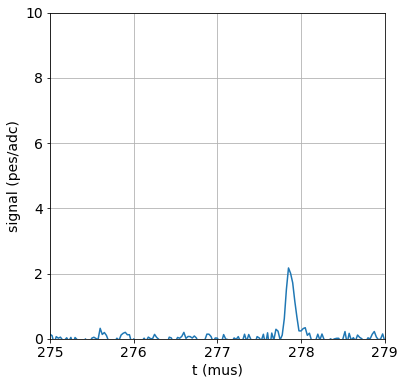

In [178]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =275,
                            t_max      = 279,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [179]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 277.825  277.85   277.875  277.9    277.925  277.95 ] µs
 Time @ max energy: 277.85
 Width: 0.125 µs
 Height: 2.172178783687757 pes
 Energy: 9.24774583957532 pes
 Charge: 0.0 pes
 RMS: 0.03730302621462035 µs]

In [180]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 648.2283726   649.25484153  650.34309782  651.27525264  652.22905994
 653.2662489   654.22830462  655.19709723  656.19003689  657.17190629
 658.10802205  659.12229757  660.22188066  660.84174085] µs
       Time @ max energy: 655.197097226768
       Width: 12.613368251259905 µs
       Height: 2029.2277917177341 pes
       Energy: 9898.362203356668 pes
       Charge: 0.0 pes
       RMS: 2.0487559159795805 µs]

- This appears to be an OK event, but energy smaller than others (however, notice lack of topological cuts)

## Event 4

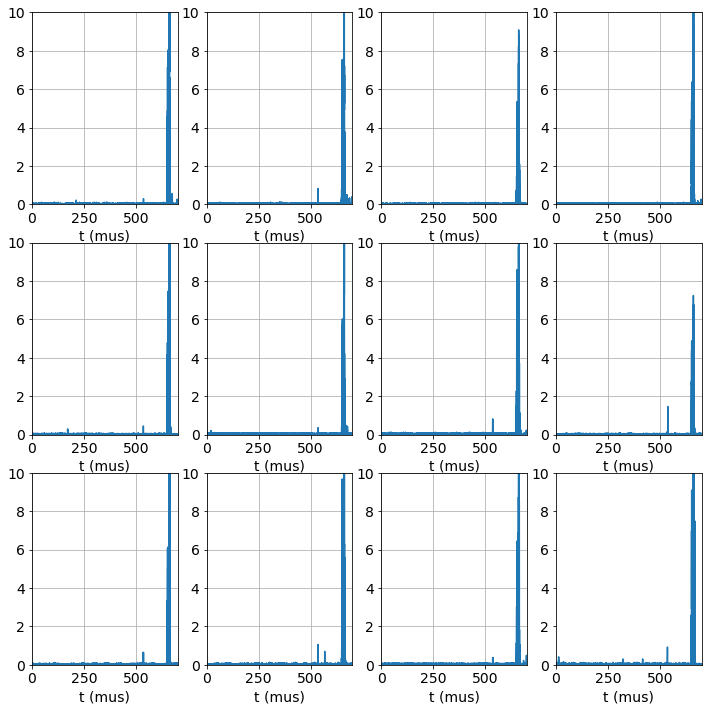

In [181]:
event=4
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    0,
                                t_max      = 700,
                                signal_min =    0,
                                signal_max =  10,
                                 figsize=(12,12))

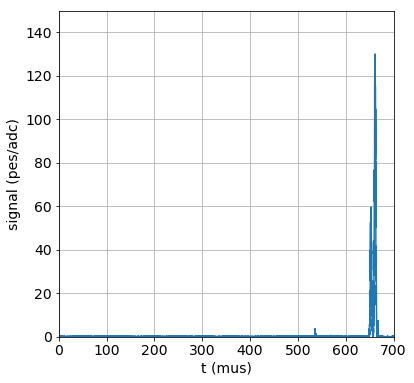

In [183]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  150,
                            figsize=(6,6))

In [184]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 535.575  535.6    535.625  535.65   535.675  535.7    535.725] µs
 Time @ max energy: 535.65
 Width: 0.15 µs
 Height: 3.609958645758052 pes
 Energy: 13.055733482958168 pes
 Charge: 0.0 pes
 RMS: 0.04482546468259437 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 8
 Times: [ 535.975  536.     536.025  536.05   536.075  536.1    536.125  536.15 ] µs
 Time @ max energy: 536.1
 Width: 0.175 µs
 Height: 3.676925395482646 pes
 Energy: 19.028741214274202 pes
 Charge: 0.0 pes
 RMS: 0.04326771658844092 µs]

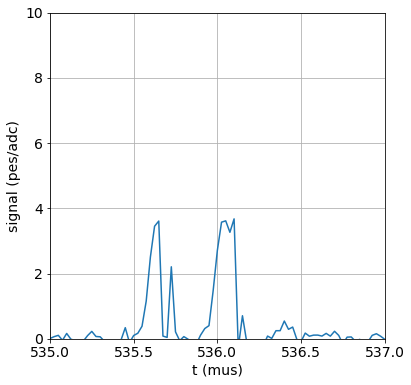

In [186]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =535,
                            t_max      = 537,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [187]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 20
       Times: [ 649.06600543  650.00493127  650.97151356  651.91359974  652.85703757
 653.79149888  654.7462323   655.79572927  656.92144183  658.06982745
 658.98294044  659.91532188  660.86939437  661.83839146  662.76241857
 663.75106804  664.77855997  665.71424645  666.73941212  667.83257157] µs
       Time @ max energy: 660.8693943705362
       Width: 18.766566139809672 µs
       Height: 4520.4485919350955 pes
       Energy: 22555.821146821014 pes
       Charge: 0.0 pes
       RMS: 4.100909441216442 µs]

#### Probably not a Krypton

## Event 5

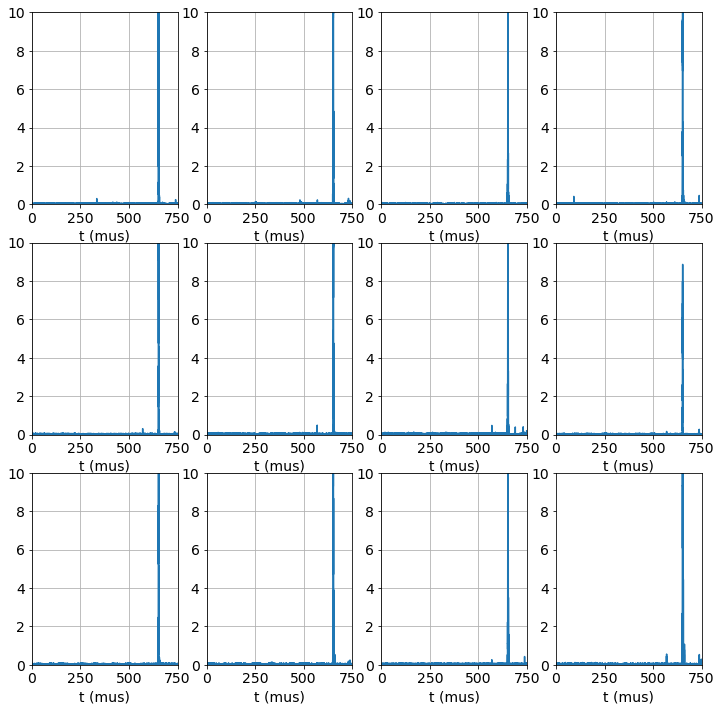

In [190]:
event=5
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    0,
                                t_max      = 750,
                                signal_min =    0,
                                signal_max =  10,
                                 figsize=(12,12))

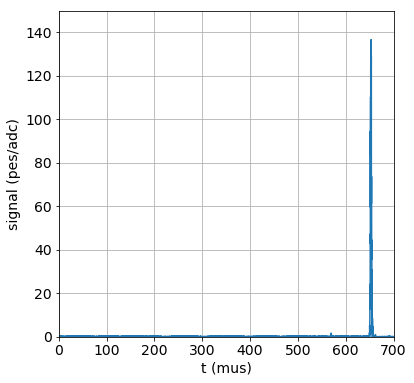

In [191]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  150,
                            figsize=(6,6))

In [192]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 569.425  569.45   569.475  569.5    569.525  569.55 ] µs
 Time @ max energy: 569.5
 Width: 0.125 µs
 Height: 1.6771543093651922 pes
 Energy: 6.445780667760479 pes
 Charge: 0.0 pes
 RMS: 0.03579866046218651 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 4
 Times: [ 569.825  569.85   569.875  569.9  ] µs
 Time @ max energy: 569.825
 Width: 0.075 µs
 Height: 1.058682579121694 pes
 Energy: 2.0527398132172032 pes
 Charge: 0.0 pes
 RMS: 0.03253345897336617 µs]

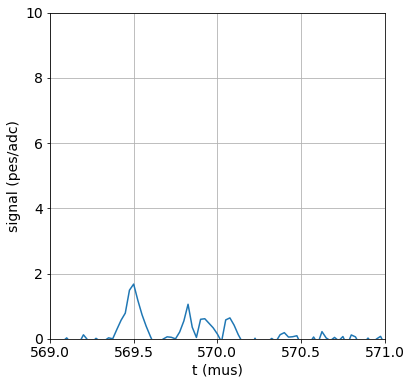

In [193]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =569,
                            t_max      = 571,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [194]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 8
       Times: [ 650.1564037   651.0932216   652.00181302  652.96251664  653.87305775
 654.7926709   655.83250194  656.78556948] µs
       Time @ max energy: 652.9625166443761
       Width: 6.629165779176634 µs
       Height: 5022.050583968987 pes
       Energy: 13117.813985197548 pes
       Charge: 0.0 pes
       RMS: 0.9704964689154799 µs]

- We see the effect of the double S1
- If the S2 is Krypton, with 13,000 pes, this suggests lifetime quite good. 

## Event 6

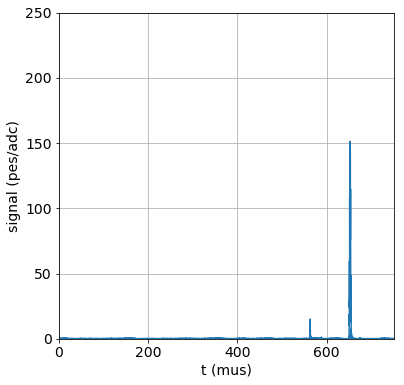

In [198]:
event=6
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [205]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 564.4    564.425  564.45   564.475  564.5  ] µs
 Time @ max energy: 564.45
 Width: 0.1 µs
 Height: 2.1724625353683518 pes
 Energy: 7.824691234799927 pes
 Charge: 0.0 pes
 RMS: 0.030121085453369993 µs, 
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 587.425  587.45   587.475  587.5    587.525] µs
 Time @ max energy: 587.525
 Width: 0.1 µs
 Height: 1.1191144011508507 pes
 Energy: 4.335075931971086 pes
 Charge: 0.0 pes
 RMS: 0.03449075196923004 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 10
       Times: [ 587.825  587.85   587.875  587.9    587.925  587.95   587.975  588.
 588.025  588.05 ] µs
       Time @ max energy: 587.875
       Width: 0.225 µs
       Height: 1.188889752282432 pes
       Energy: 5.412232415183533 pes
       Charge: 0.0 pes
       RMS: 0.06826510971087754 µs]

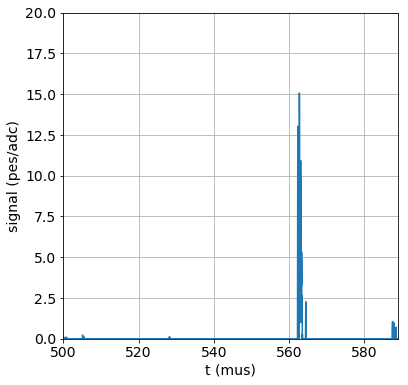

In [208]:
sf.plot_signal_vs_time_mus(cwf_sum_mau,
                            t_min      =500,
                            t_max      = 589,
                            signal_min =    0,
                            signal_max =  20,
                            figsize=(6,6))

In [207]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 8
       Times: [ 649.62081731  650.80706321  651.72040747  652.61979909  653.50694995
 654.46981882  655.46074223  656.39390797] µs
       Time @ max energy: 652.6197990927133
       Width: 6.773090653228922 µs
       Height: 5412.414862124249 pes
       Energy: 12824.777436173703 pes
       Charge: 0.0 pes
       RMS: 0.8693470770515475 µs]

#### Probably a background event

## Event 7

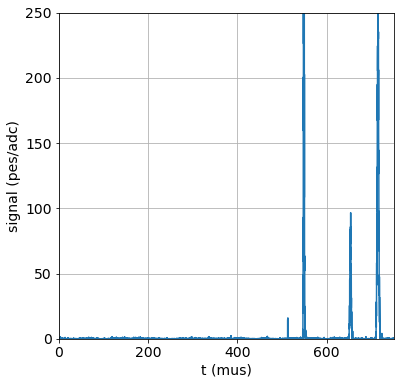

In [209]:
event=7
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

## Event 8

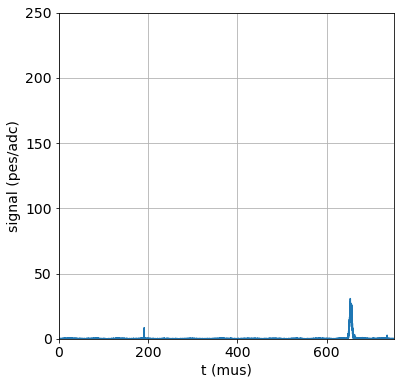

In [210]:
event=8
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [211]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 19
       Times: [ 191.225  191.25   191.275  191.3    191.325  191.35   191.375  191.4
 191.425  191.45   191.475  191.5    191.525  191.55   191.575  191.6
 191.625  191.65   191.675] µs
       Time @ max energy: 191.35
       Width: 0.45 µs
       Height: 8.54385953668005 pes
       Energy: 50.59868338600795 pes
       Charge: 0.0 pes
       RMS: 0.10029019742953094 µs]

In [212]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 26
       Times: [ 646.21022511  647.40854231  648.37614016  649.26635942  650.31452968
 651.26132557  652.25730417  653.23422835  654.23496944  655.22882963
 656.1840471   657.2121635   658.16361713  659.2124591   660.16960613
 661.1554447   662.19041943  663.25906294  664.29512401  665.10661166
 666.08803174  667.18427849  668.26575797  669.18055876  670.21163211
 671.00757067] µs
       Time @ max energy: 653.2342283512065
       Width: 24.797345555647393 µs
       Height: 938.9965442798396 pes
       Energy: 6082.106245753259 pes
       Charge: 0.0 pes
       RMS: 2.910351154784367 µs]

#### Probably low energy backgrond events

## Event 9

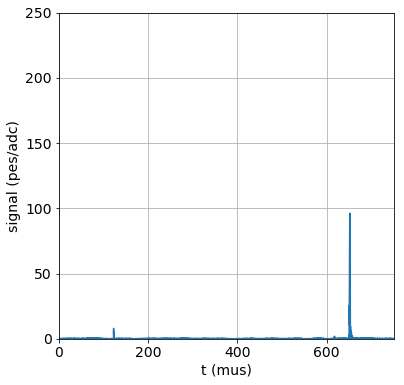

In [214]:
event=9
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [222]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[]

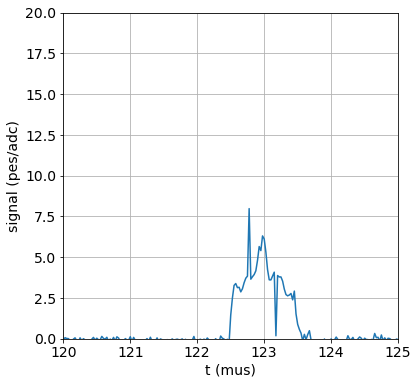

In [223]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =120,
                            t_max      = 125,
                            signal_min =    0,
                            signal_max =  20,
                            figsize=(6,6))

In [216]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 7
       Times: [ 650.73207335  651.50733825  652.37376466  653.28848175  654.24229719
 655.32093226  656.02915446] µs
       Time @ max energy: 651.5073382466311
       Width: 5.297081110801548 µs
       Height: 3070.401241447256 pes
       Energy: 6599.046688151999 pes
       Charge: 0.0 pes
       RMS: 0.666170975561869 µs]

## Event 10

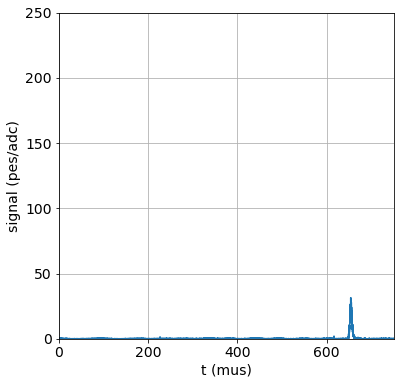

In [224]:
event=10
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

## Event 11

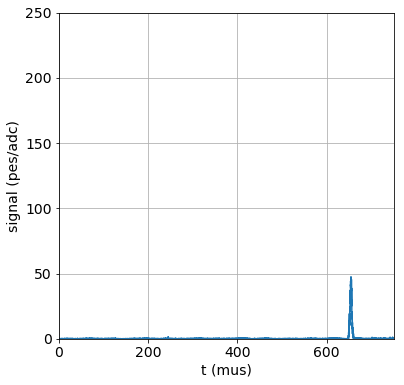

In [225]:
event=11
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

## Event 12

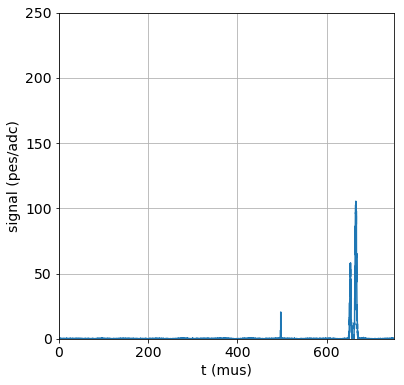

In [226]:
event=12
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [227]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 496.775  496.8    496.825  496.85   496.875  496.9    496.925] µs
 Time @ max energy: 496.775
 Width: 0.15 µs
 Height: 6.605809338773452 pes
 Energy: 14.197269028562543 pes
 Charge: 0.0 pes
 RMS: 0.04818355210179539 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 13
       Times: [ 497.05   497.075  497.1    497.125  497.15   497.175  497.2    497.225
 497.25   497.275  497.3    497.325  497.35 ] µs
       Time @ max energy: 497.125
       Width: 0.3 µs
       Height: 20.541177326918575 pes
       Energy: 100.0469025479928 pes
       Charge: 0.0 pes
       RMS: 0.054568283494587276 µs]

In [228]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 10
       Times: [ 649.56228295  650.47317083  651.43486631  652.39803258  653.31440892
 654.29931269  655.24944476  656.23508704  657.21250469  658.12037131] µs
       Time @ max energy: 653.3144089186528
       Width: 8.558088352676597 µs
       Height: 1968.1539270287822 pes
       Energy: 6962.745577520935 pes
       Charge: 0.0 pes
       RMS: 1.3327115713553053 µs, 
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 12
       Times: [ 660.03872981  661.18376007  662.03736146  663.07415065  664.03328595
 664.99527226  665.98004362  666.91811677  667.90539964  668.86494109
 669.90398227  670.82579558] µs
       Time @ max energy: 665.9800436201225
       Width: 10.78706576955237 µs
       Height: 3823.545724505977 pes
       Energy: 15810.976558789143 pes
       Charge: 0.0 pes
       RMS: 1.523795679942792 µs, 
       --------

## Event 13 

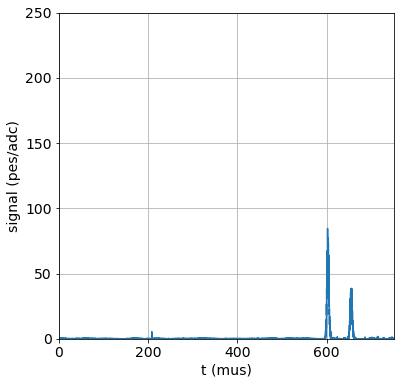

In [229]:
event=13
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [230]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 9
       Times: [ 208.125  208.15   208.175  208.2    208.225  208.25   208.275  208.3
 208.325] µs
       Time @ max energy: 208.2
       Width: 0.2 µs
       Height: 5.027431459421855 pes
       Energy: 18.946919014060164 pes
       Charge: 0.0 pes
       RMS: 0.04797742257456673 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 9
       Times: [ 208.525  208.55   208.575  208.6    208.625  208.65   208.675  208.7
 208.725] µs
       Time @ max energy: 208.6
       Width: 0.2 µs
       Height: 5.035823175455931 pes
       Energy: 26.667387768267556 pes
       Charge: 0.0 pes
       RMS: 0.049024103048667056 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 11
       Times: [ 605.025  605.05   605.075  605.1    605.125  605.15   605.175  605.2
 605.225  605.25   605.2

## Event 14

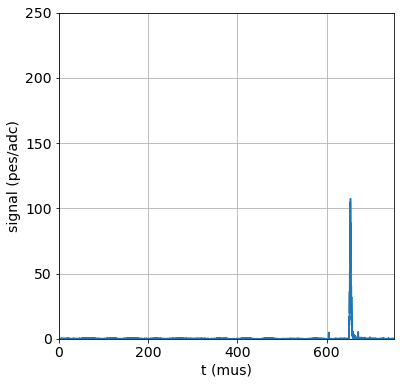

In [231]:
event=14
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [232]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 604.425  604.45   604.475  604.5    604.525] µs
 Time @ max energy: 604.425
 Width: 0.1 µs
 Height: 4.117100535570109 pes
 Energy: 11.515941072872241 pes
 Charge: 0.0 pes
 RMS: 0.03401738088166526 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 11
       Times: [ 604.8    604.825  604.85   604.875  604.9    604.925  604.95   604.975
 605.     605.025  605.05 ] µs
       Time @ max energy: 604.85
       Width: 0.25 µs
       Height: 4.963517788028963 pes
       Energy: 19.33255615861085 pes
       Charge: 0.0 pes
       RMS: 0.057628944674135346 µs]

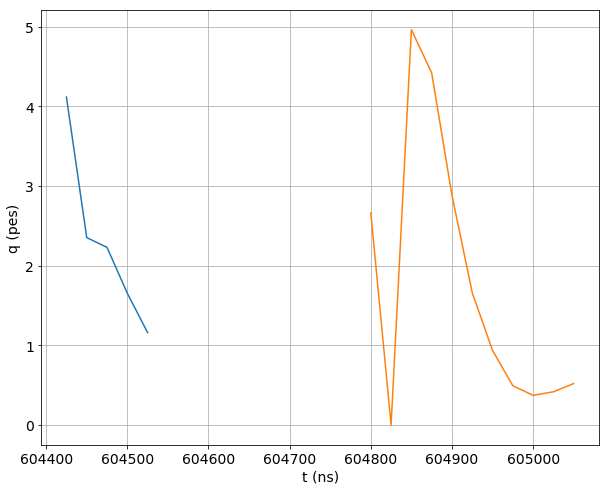

In [235]:
plot_S12(s1s)

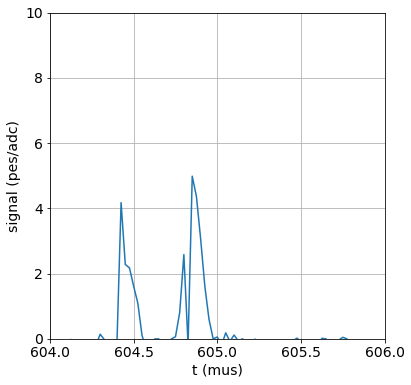

In [236]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =604,
                            t_max      = 606,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

- double peak 

In [233]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 24
       Times: [ 649.97256702  650.85940532  651.81317312  652.74120509  653.68362281
 654.64899891  655.64668553  656.62137897  657.65051172  658.64018987
 659.69752855  660.68526807  661.70856991  662.73226555  663.58966674
 664.87555144  665.52118644  666.59838335  667.80658891  668.8330554
 669.88063769  670.64495109  671.56192234  672.40863972] µs
       Time @ max energy: 652.7412050888942
       Width: 22.436072699109676 µs
       Height: 3458.4477805388606 pes
       Energy: 13568.671354380818 pes
       Charge: 0.0 pes
       RMS: 2.2617272810180067 µs, 
 ---------------------
 S2 instance
 ---------------------
 Number of samples: 4
 Times: [ 684.38088716  685.4702863   686.31532697  687.15983389] µs
 Time @ max energy: 685.4702862950182
 Width: 2.778946730725933 µs
 Height: 9.196595674018745 pes
 Energy: 21.559413476497205 pes
 Charge: 0.0 pes
 RMS: 0.8195194272801225 µ

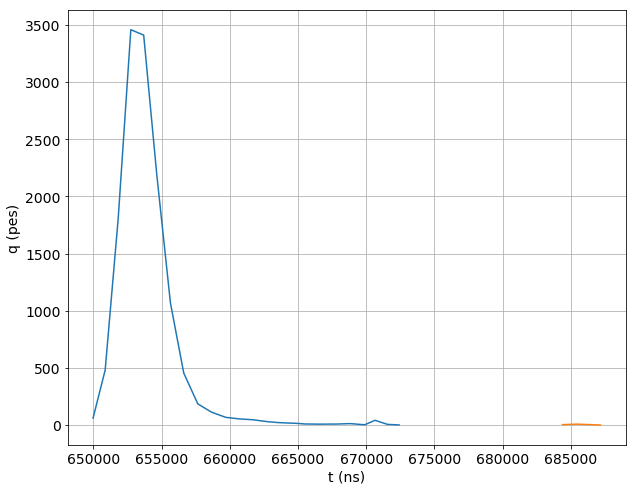

In [234]:
plot_S12(s2s)

In [272]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 648.70072653  649.66381752  650.678766    651.65606818  652.63988717
 653.61900037  654.61594392  655.58320442  656.56569644  657.56725464
 658.53077067  659.5430227   660.51445007  661.62537538] µs
       Time @ max energy: 654.6159439229183
       Width: 12.92464885085111 µs
       Height: 2203.562850790142 pes
       Energy: 12362.19259177607 pes
       Charge: 0.0 pes
       RMS: 2.2591161145243 µs]

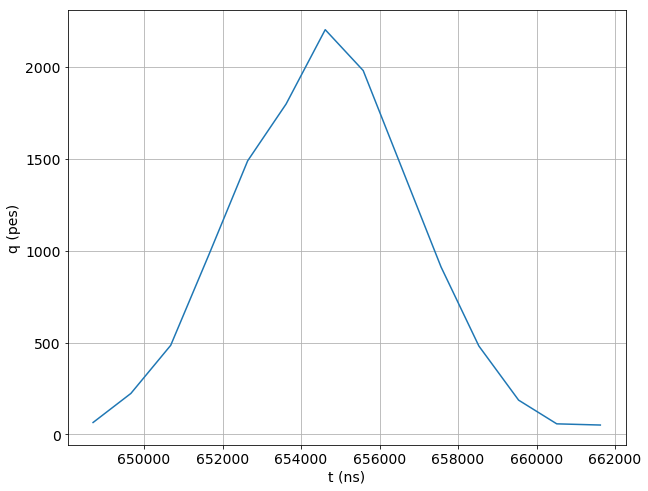

In [273]:
plot_S12(s2s)

### Conclusions

- Deconvolution correct
- S1 doubling. Effect not understood.
- S2 cut at 1 pes kills tails.
- We seem to have very little Krypton and some background
- I